# Imports

In [1]:
!pip install ultralytics
!pip install fiftyone
!pip install mediapipe
import mediapipe as mp
from google.colab import drive
import json
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
from ultralytics import YOLO
import torch


# Test the YOLO-model on a default image

100%|██████████| 5.97M/5.97M [00:00<00:00, 73.1MB/s]


100%|██████████| 134k/134k [00:00<00:00, 5.45MB/s]


image 1/1 /content/bus.jpg: 640x480 4 persons, 71.4ms
Speed: 15.6ms preprocess, 71.4ms inference, 389.4ms postprocess per image at shape (1, 3, 640, 480)


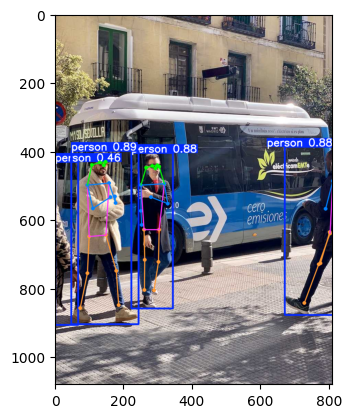

In [2]:
model = YOLO("yolo11n-pose.pt")
results = model("https://ultralytics.com/images/bus.jpg")

for result in results:
    im_array = result.plot()
    plt.imshow(cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB))
    plt.show()

# Load and filter HMDB51-dataset

In [2]:
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.utils.video as fouv
import fiftyone.core.media as fom

dataset = foz.load_zoo_dataset("hmdb51", split="train")

Split 'train' already downloaded


INFO:fiftyone.zoo.datasets:Split 'train' already downloaded


Loading existing dataset 'hmdb51-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'hmdb51-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


Filter unwanted labels. Since the YOLO nano model does not have facial and finger keypoint detection, some of the ground truths will be quite difficult to classify. We can either use a more advanced detection model which will be more expensive (time- and computation wise), or remove the labels entirely.

In [3]:
labels_to_remove = ["brush_hair", "chew", "drink", "eat", "laugh", "smile", "smoke", "talk", "cartwheel"]

filtered_dataset = dataset.filter_labels("ground_truth", fo.ViewField("label").is_in(labels_to_remove))

dataset.delete_samples(filtered_dataset.values("id"))

Define method for counting the frames in a video

In [4]:
def count_frames(video_path):
  try:
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
      return -1

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()  # Release the video capture object
    return frame_count
  except Exception as e:
    print(f"Error: {e}")
    return -1

Count the amount of frames and calculate average, min, max and median.

In [5]:
frame_counts = []
ids_of_longest_videos = []
for sample in dataset:
  video_path = sample.filepath
  num_frames = count_frames(video_path)
  if num_frames != -1:
    frame_counts.append(num_frames)
  if num_frames > 300:
    ids_of_longest_videos.append(sample.id)

avg_frames = np.mean(frame_counts)
median = np.median(frame_counts)
max_frames = np.max(frame_counts)
min_frames = np.min(frame_counts)

print(f"Average number of frames: {avg_frames}")
print(f"Median number of frames: {median}")
print(f"Maximum number of frames: {max_frames}")
print(f"Minimum number of frames: {min_frames}")
print(f"Total number of samples: {len(frame_counts)}")
print(f"Number of videos with more than 300 frames: {len(ids_of_longest_videos)}")

Average number of frames: 84.2955647955648
Median number of frames: 79.0
Maximum number of frames: 300
Minimum number of frames: 19
Total number of samples: 2886
Number of videos with more than 300 frames: 0


Plot the number of frames

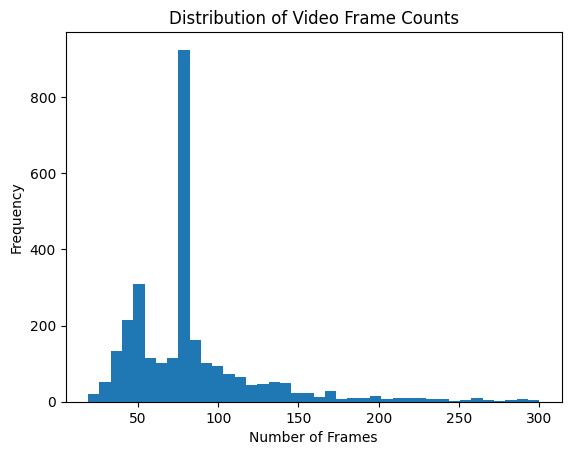

In [6]:
import matplotlib.pyplot as plt
plt.hist(frame_counts, bins=40)

plt.xlabel("Number of Frames")
plt.ylabel("Frequency")
plt.title("Distribution of Video Frame Counts")

plt.show()

Delete the longest videos from the dataset

In [7]:
dataset.delete_samples(ids_of_longest_videos)

# Load and test YOLO-model on dataset

In [8]:
from ultralytics import YOLO

model = YOLO("yolo11l-pose.pt")

In [9]:
video_path = dataset.first().filepath

results = model.track(source=video_path, show=True, save=True, stream=True)

keypoints = []
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen

Output hidden; open in https://colab.research.google.com to view.

In [10]:
print(keypoints)

ultralytics.engine.results.Keypoints object with attributes:

conf: tensor([[0.8871, 0.9333, 0.8895, 0.7408, 0.6390, 0.7628, 0.5848, 0.0475, 0.0160, 0.0328, 0.0147, 0.0194, 0.0132, 0.0120, 0.0088, 0.0238, 0.0183]], device='cuda:0')
data: tensor([[[1.1487e+02, 2.1891e+02, 8.8708e-01],
         [1.1853e+02, 2.1614e+02, 9.3332e-01],
         [1.1188e+02, 2.1568e+02, 8.8948e-01],
         [1.2429e+02, 2.1815e+02, 7.4077e-01],
         [1.0776e+02, 2.1722e+02, 6.3902e-01],
         [1.3244e+02, 2.3593e+02, 7.6283e-01],
         [1.0680e+02, 2.3699e+02, 5.8482e-01],
         [0.0000e+00, 0.0000e+00, 4.7481e-02],
         [0.0000e+00, 0.0000e+00, 1.6016e-02],
         [0.0000e+00, 0.0000e+00, 3.2780e-02],
         [0.0000e+00, 0.0000e+00, 1.4680e-02],
         [0.0000e+00, 0.0000e+00, 1.9420e-02],
         [0.0000e+00, 0.0000e+00, 1.3179e-02],
         [0.0000e+00, 0.0000e+00, 1.2001e-02],
         [0.0000e+00, 0.0000e+00, 8.7981e-03],
         [0.0000e+00, 0.0000e+00, 2.3814e-02],
         [

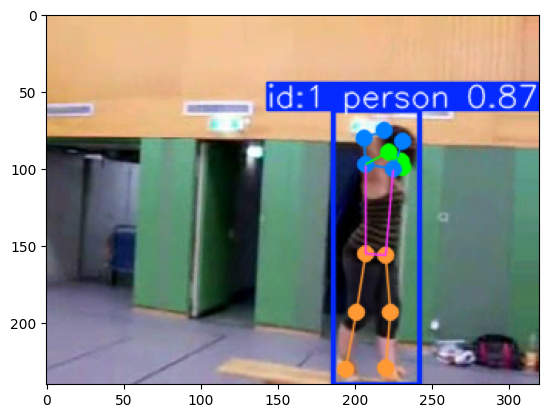

In [12]:
import matplotlib.pyplot as plt
# Iterate through the results and find the specified frame
im_array = result.plot()  # plot a BGR numpy array of predictions
plt.imshow(cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB))
plt.show()

# View dataset in FiftyOne-app

To view the dataset in the fo-app we need to reencode the dataset first.

In [13]:
reencoded = fouv.reencode_videos(dataset)

   2% |/--------------|   48/2956 [13.8s elapsed, 13.9m remaining, 3.7 samples/s] 


INFO:eta.core.utils:   2% |/--------------|   48/2956 [13.8s elapsed, 13.9m remaining, 3.7 samples/s] 


KeyboardInterrupt: 

In [ ]:
session = fo.launch_app(dataset)

# Preprocessing dataset

Define method to convert from a YOLO-result to a numpy array. The result will be converted from tensors to an array that can be used as an input to a model. For example the result of this function will be a numpy array of shape [85, 34] when given number_of_frames=85. 34 is the number of keypoints (17 keypoints times 2, since keypoints are a 2D coordinate)

In [14]:
def convert_to_np_array(keypoints, number_of_frames):

    filtered_keypoints = [k for k in keypoints if k.size() != torch.Size([0])]

    # If no keypoints are detected in any frame, return an empty array
    if not filtered_keypoints:
        return np.empty((0, 34))

    keypoints_tensor = torch.cat(filtered_keypoints, dim=0)
    # Extract number of persons from tensor shape
    num_keypoints_per_frame = keypoints_tensor.shape[1] * keypoints_tensor.shape[2]

    #Calculate the actual number of detected frames
    actual_frames = keypoints_tensor.shape[0]

    #Adjust num_persons to match the actual dimensions
    # num_persons = actual_frames // number_of_frames #This line causes the error as num_persons might not be a whole number

    # Reshape considering the actual dimensions
    # keypoints_reshaped = keypoints_tensor.view(num_persons, number_of_frames, num_keypoints_per_frame) # This line throws error due to dimension mismatch
    keypoints_reshaped = keypoints_tensor.view(actual_frames, num_keypoints_per_frame) #Reshape to [number_of_detected_frames, num_keypoints_per_frame] to fix the mismatch

    # Select the data for the first person
    # Adjust the indexing based on the assumption of the first person being at index 0
    #keypoints_reshaped = keypoints_reshaped[0] # This line assumes that the first dimension is for persons, remove it

    keypoints_array = keypoints_reshaped.numpy()
    return keypoints_array

In [15]:
# Load YOLO model
model = YOLO("yolo11s-pose.pt")

# Initialize dataset for LSTM
lstm_dataset = []

# Iterate through the FiftyOne dataset
for sample in dataset:
    video_path = sample.filepath
    label = sample.ground_truth.label  # Get the ground truth label
    num_frames = count_frames(video_path)  # Using your count_frames function

    # Process with YOLO and extract keypoints
    results = model.track(source=video_path, show=False, save=False, stream=True)
    keypoints = []
    for result in results:
        xyn = result.keypoints.xyn  # Normalized keypoints
        keypoints.append(xyn)

    # Convert keypoints to NumPy array
    keypoints_array = convert_to_np_array(keypoints, num_frames)

    # Add to LSTM dataset
    lstm_dataset.append({
        "keypoints": keypoints_array,
        "label": label
    })

print("LSTM dataset created!")

100%|██████████| 19.4M/19.4M [00:00<00:00, 135MB/s] 



video 1/1 (frame 1/84) /root/fiftyone/hmdb51/train/cartwheel/(Rad)Schlag_die_Bank!_cartwheel_f_cm_np1_le_med_0.mp4: 480x640 1 person, 50.1ms
video 1/1 (frame 2/84) /root/fiftyone/hmdb51/train/cartwheel/(Rad)Schlag_die_Bank!_cartwheel_f_cm_np1_le_med_0.mp4: 480x640 1 person, 11.4ms
video 1/1 (frame 3/84) /root/fiftyone/hmdb51/train/cartwheel/(Rad)Schlag_die_Bank!_cartwheel_f_cm_np1_le_med_0.mp4: 480x640 1 person, 11.1ms
video 1/1 (frame 4/84) /root/fiftyone/hmdb51/train/cartwheel/(Rad)Schlag_die_Bank!_cartwheel_f_cm_np1_le_med_0.mp4: 480x640 1 person, 10.9ms
video 1/1 (frame 5/84) /root/fiftyone/hmdb51/train/cartwheel/(Rad)Schlag_die_Bank!_cartwheel_f_cm_np1_le_med_0.mp4: 480x640 1 person, 11.3ms
video 1/1 (frame 6/84) /root/fiftyone/hmdb51/train/cartwheel/(Rad)Schlag_die_Bank!_cartwheel_f_cm_np1_le_med_0.mp4: 480x640 1 person, 11.5ms
video 1/1 (frame 7/84) /root/fiftyone/hmdb51/train/cartwheel/(Rad)Schlag_die_Bank!_cartwheel_f_cm_np1_le_med_0.mp4: 480x640 1 person, 11.0ms
video 1/1 (f

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 17 but got size 0 for tensor number 58 in the list.

# Stuff

In [11]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment


In [12]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.5 ; cuda:  cu124
detectron2: 0.6


In [13]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [14]:

import cv2
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Load the configuration for the keypoint detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Set the confidence threshold
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

# Create a predictor object
predictor = DefaultPredictor(cfg)

# Get the video path from your dataset
video_path = dataset.first().filepath  # Use the first video in the dataset

# Open the video file
video = cv2.VideoCapture(video_path)

# Get video properties for output video
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video.get(cv2.CAP_PROP_FPS))

# Create a VideoWriter object to save the output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use appropriate codec
output_video_path = 'output_keypoints.mp4'  # Choose an output path
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

while(video.isOpened()):
    ret, frame = video.read()
    if ret:
        # Perform keypoint detection on the frame
        outputs = predictor(frame)

        # Visualize the predictions
        v = Visualizer(frame[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
        out_frame = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()[:, :, ::-1]

        # Write the frame to the output video
        out.write(out_frame)

        # Display the frame (optional)
        cv2_imshow(out_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Release resources
video.release()
out.release()
cv2.destroyAllWindows()
print(f"Keypoint detection video saved to: {output_video_path}")

Output hidden; open in https://colab.research.google.com to view.